# Cluster Analysis




In [1]:
import sys
sys.path.append("..")
from benchmark.results import load_all_results
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, rand_score


sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style("whitegrid")
palette = sns.color_palette("colorblind")

In [2]:
dataset = 'glove' # 'glove', 'gist', 'pamap2', 'household', 'mnist', 'celeba', 'census, 'aloi'
exact_algorithm = 'faiss' # for high-dimensional datasets, this has to be 'faiss'

data = []
data2 = []

# load all the results that are available for the dataset
for f in load_all_results(dataset, ".."):
    # filter by the exact algorithm
    if f.attrs['algo'] == exact_algorithm and f.attrs['minPts'] == 100:
        labels = np.array(f['labels'])
        points_clustered = len([x for x in np.array(labels) if x >= 0])
        largest_cluster_size = 0
        if len(labels[labels > -1]) > 0:
            largest_cluster_size = max(Counter(labels[labels > -1]).values())/len(labels)
        data.append({
            "eps": f.attrs['eps'],
            "minPts": f.attrs['minPts'],
            "n": len(labels),
            "num_clusters": len(set(labels)),
            "largest_cluster_size": largest_cluster_size, 
            "num_corepoints": len(f['corepoints']),
            "num_noncorepoints": len(labels) - len(f['corepoints']),
            "points_clustered": points_clustered,
            "fraction_clustered": points_clustered/len(labels),
            "fraction_noise": len([x for x in np.array(labels) if x < 0])/len(labels),
            "cluster_sizes": sorted(Counter(labels[labels > -1]).values(),reverse=True),
            "Params": f.attrs['params'],
            #"time": f.attrs['time'],
            })
    if f.attrs['algo'] == 'srrdbscan' and 'delta=0.1' in f.attrs['params'] and f.attrs['minPts'] == 100:
        data2.append({
            "eps": f.attrs['eps'],
            "time": f.attrs['time']
            })

df = pd.DataFrame(data=data)
df2 = pd.DataFrame(data=data2)
df

,eps,minPts,n,num_clusters,largest_cluster_size,num_corepoints,num_noncorepoints,points_clustered,fraction_clustered,fraction_noise,cluster_sizes,Params
0,20.0,100,1183514,1,1.000000,1183514,0,1183514,1.000000,0.000000,[1183514],FAISSDBSCAN()
1,15.0,100,1183514,2,0.999997,1183507,7,1183511,0.999997,0.000003,[1183511],FAISSDBSCAN()
2,4.0,100,1183514,38,0.302203,148653,1034861,358026,0.302511,0.697489,"[357662, 62, 54, 37, 22, 22, 15, 15, 13, 10, 9...",FAISSDBSCAN()
3,2.0,100,1183514,19,0.003168,1644,1181870,3914,0.003307,0.996693,"[3749, 59, 14, 12, 11, 10, 9, 9, 7, 7, 7, 5, 4...",FAISSDBSCAN()
4,10.0,100,1183514,2,0.999491,1181890,1624,1182912,0.999491,0.000509,[1182912],FAISSDBSCAN()


In [3]:
df2.sort_values('eps')

,eps,time
2,1.0,90.067088
5,2.0,176.140738
4,4.0,193.685731
0,4.5,182.359663
6,5.0,165.847790
8,6.0,133.884398
7,10.0,101.099637
3,15.0,100.217807
1,20.0,99.216774


Text(0.5, 1.0, 'Number of clusters for glove with minPts=100')

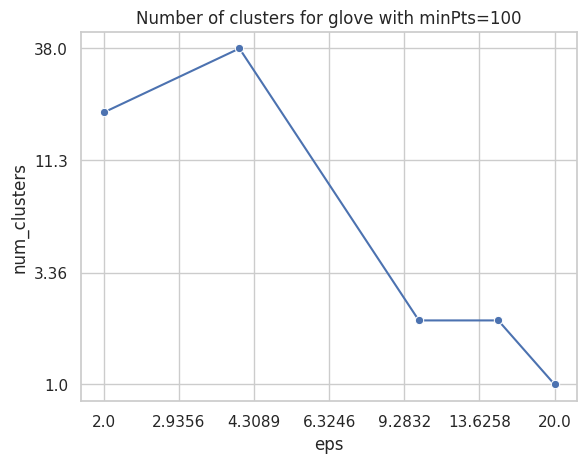

In [4]:
minPts = 100

# sns.set(style="darkgrid")
x_log_min = np.log10(min(df['eps']))
x_log_max = np.log10(max(df['eps']))
xticks = np.logspace(x_log_min, x_log_max, num = 7)
xticks = [round(x, 4) for x in xticks]

y_log_min = np.log10(min(df['num_clusters']))
y_log_max = np.log10(max(df['num_clusters']))
yticks = np.logspace(y_log_min, y_log_max, num = 4)
yticks = [round(x, 2) for x in yticks]

ax = sns.lineplot(data=df, x='eps', y='num_clusters', marker='o')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.minorticks_on()
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
plt.title(f"Number of clusters for {dataset} with minPts={minPts}")


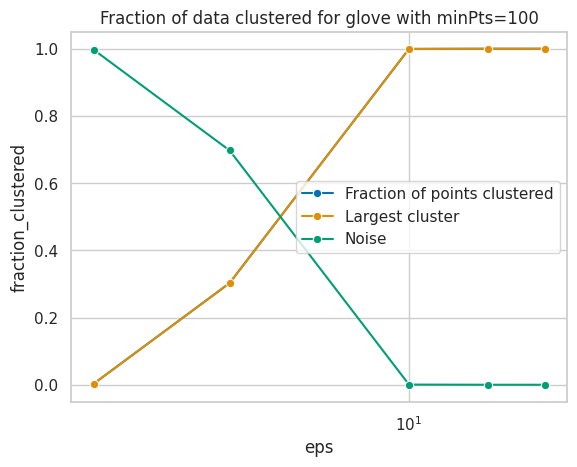

In [ ]:
ax = sns.lineplot(data=df, x='eps', y='fraction_clustered', marker='o', label="Fraction of points clustered", color=palette[0])
sns.lineplot(ax=ax, data=df, x='eps', y='largest_cluster_size', marker='o', label="Largest cluster", color=palette[1])
sns.lineplot(ax=ax, data=df, x='eps', y='fraction_noise', marker='o', label="Noise", color=palette[2])
#ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
plt.title(f"Fraction of data clustered for {dataset} with minPts={minPts}")
plt.legend(loc='center right')

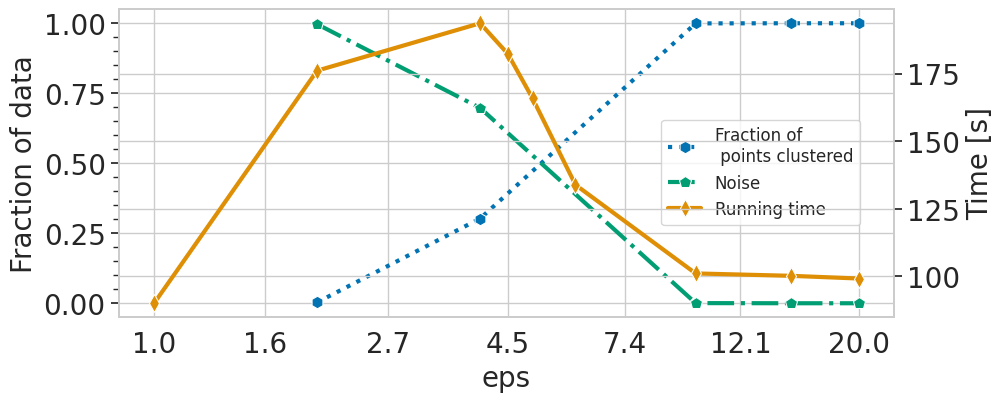

In [11]:
fontsize = 20
ms = 9
thickness = 3
x_log_min = np.log10(min(df2['eps']))
x_log_max = np.log10(max(df2['eps']))

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax = sns.lineplot(data=df, x='eps', y='fraction_clustered', 
            marker='h', 
            ms=ms,
            label="Fraction of \n points clustered",
            linestyle=":",
            linewidth=thickness, 
            color=palette[0])
sns.lineplot(ax=ax, data=df, x='eps', y='fraction_noise', 
             marker='p', 
             label="Noise", 
             ms=ms,
             linestyle="-.",
             linewidth=thickness,
             color=palette[2])
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=df2, x='eps', y='time', 
             marker='d', 
             ms=ms,
             label="Running time", 
             linewidth=thickness,
             color=palette[1])
#ax.set_yscale('log')
#ax.set_xlim(1000) # for mnist
ax.set_xscale('log')
ax.set_ylabel('Fraction of data' , fontsize=fontsize)
#ax.get_yaxis().set_visible(False)
ax2.set_ylabel('Time [s]' , fontsize=fontsize)
ax.set_xlabel('eps', fontsize=fontsize)
ax.minorticks_on()

# Collect handles and labels from both axes
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine the handles and labels
handles += handles2
labels += labels2

# Setting gridlines and ticks
xticks = np.logspace(x_log_min, x_log_max, num = 7)
xticks = [round(x, 1) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=fontsize)
ax.yaxis.set_tick_params(labelsize = fontsize)
ax2.yaxis.set_tick_params(labelsize = fontsize)

# Create a single legend
ax2.get_legend().remove()
ax.legend(handles, labels, fontsize=12, loc=(0.7, 0.30))

# Cluster Quality

In [39]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

dataset = 'glove'

exact_algorithm = 'faiss'

In [40]:
data = []

exact_data = {}
for f in load_all_results(dataset, ".."):
    if f.attrs['algo'] == exact_algorithm:
        exact_data[f.attrs['eps']] = (np.array(f['labels']), np.array(f['corepoints']), np.array(f['borderpoints']))
    else:
        data.append({
            "clustering": np.array(f['labels']),
            "time": f.attrs['time'],
            "algo": f.attrs['algo'],
            "eps": f.attrs['eps'],
            "params": f.attrs.get("params", "")
        })


metrics = []

for eps, (gt_labels, corepoints, borderpoints) in exact_data.items():
    filtered_data = [d for d in data if d['eps'] == eps]
    # remove border points
    gt_labels[borderpoints] = -1
    for d in filtered_data:
        labels = d["clustering"]
        labels[borderpoints] = -1
        metrics.append({
            "eps": eps,
            "time": d['time'],
            "algo": d["algo"],
            "ARI": adjusted_rand_score(gt_labels, labels),
            "NMI": normalized_mutual_info_score(gt_labels, labels),
            "params": d.get("params", "")
        })

quality_df = pd.DataFrame(metrics)
quality_df.sort_values(by=["eps", "ARI", "NMI"])

,eps,time,algo,ARI,NMI,params
15,2.0,41.924606,srrdbscan,0.459150,0.362771,"SRRDBSCAN(delta=0.9, memory=5, threads=56, shr..."
18,2.0,1064.844892,sngdbscan,0.849794,0.693244,SNGDBSCAN(p=0.01)
16,2.0,84.564185,srrdbscan,0.875851,0.756580,"SRRDBSCAN(delta=0.5, memory=5, threads=56, shr..."
17,2.0,176.140738,srrdbscan,0.930968,0.818050,"SRRDBSCAN(delta=0.1, memory=5, threads=56, shr..."
14,2.0,328.482831,srrdbscan,0.943738,0.835793,"SRRDBSCAN(delta=0.01, memory=5, threads=56, sh..."
10,4.0,46.643279,srrdbscan,0.278471,0.227197,"SRRDBSCAN(delta=0.9, memory=5, threads=56, shr..."
11,4.0,89.508529,srrdbscan,0.627367,0.515839,"SRRDBSCAN(delta=0.5, memory=5, threads=56, shr..."
12,4.0,193.685731,srrdbscan,0.826762,0.718674,"SRRDBSCAN(delta=0.1, memory=5, threads=56, shr..."
9,4.0,353.096538,srrdbscan,0.916653,0.836537,"SRRDBSCAN(delta=0.01, memory=5, threads=56, sh..."
13,4.0,18017.618588,tpedbscan,0.999283,0.996755,


In [41]:
for i in range(len(quality_df)):
    if quality_df['algo'][i] == 'srrdbscan':
        if "approx" in quality_df['params'][i]:
            if "approx=1.0" in quality_df['params'][i]:
                print(quality_df['params'][i][16:35].split(",")[0], str("&"),
                    quality_df['eps'][i], str("&"),
                    round(quality_df['time'][i], 2), str("&"),
                    round(quality_df['ARI'][i], 4), str(r"\\"))
        elif "approx" not in quality_df['params'][i]:
            print(quality_df['params'][i][16:35].split(",")[0], str("&"),
                quality_df['eps'][i], str("&"),
                round(quality_df['time'][i], 2), str("&"),
                round(quality_df['ARI'][i], 4), str(r"\\"))

0.01 & 20.0 & 114.27 & 1.0 \\
0.9 & 20.0 & 55.12 & 0.0 \\
0.5 & 20.0 & 89.83 & 0.0 \\
0.1 & 20.0 & 99.22 & 1.0 \\
0.01 & 15.0 & 114.56 & 0.8235 \\
0.9 & 15.0 & 54.29 & 0.0001 \\
0.5 & 15.0 & 89.91 & 0.1609 \\
0.1 & 15.0 & 100.22 & 0.7368 \\
0.01 & 4.0 & 353.1 & 0.9167 \\
0.9 & 4.0 & 46.64 & 0.2785 \\
0.5 & 4.0 & 89.51 & 0.6274 \\
0.1 & 4.0 & 193.69 & 0.8268 \\
0.01 & 2.0 & 328.48 & 0.9437 \\
0.9 & 2.0 & 41.92 & 0.4592 \\
0.5 & 2.0 & 84.56 & 0.8759 \\
0.1 & 2.0 & 176.14 & 0.931 \\
0.01 & 10.0 & 116.13 & 0.827 \\
0.9 & 10.0 & 53.89 & 0.0111 \\
0.5 & 10.0 & 93.01 & 0.4849 \\
0.1 & 10.0 & 101.1 & 0.732 \\


# Running time plot

In [42]:
data = []

for i in range(len(pd.DataFrame(metrics)['ARI'])):
    if pd.DataFrame(metrics)['ARI'][i] > 0.7:
        data.append({
            "time": pd.DataFrame(metrics)['time'][i],
            "algo": pd.DataFrame(metrics)['algo'][i],
            "eps": pd.DataFrame(metrics)['eps'][i],
            })

df = pd.DataFrame(data)
df = pd.DataFrame(df.sort_values(by=["algo", "eps", "time"],ignore_index=True))

times = []
times.append({
    "time": df['time'][0],
    "algo": df['algo'][0],
    "eps": df['eps'][0],
})
for i in range(1, len(df['time'])):
    if df['eps'][i] != df['eps'][i-1] or df['algo'][i] != df['algo'][i-1]:
        times.append({
            "time": df['time'][i],
            "algo": df['algo'][i],
            "eps": df['eps'][i],
        })

for f in load_all_results(dataset, ".."):
    if f.attrs['algo'] == exact_algorithm:
        times.append({
            "time": f.attrs['time'],
            "algo": f.attrs['algo'],
            "eps": f.attrs['eps'],
        })

times = pd.DataFrame(times)

[Text(0, 84.56, '84.56'),
 Text(0, 325.17, '325.17'),
 Text(0, 1250.35, '1250.35'),
 Text(0, 4807.86, '4807.86'),
 Text(0, 18487.31, '18487.31')]

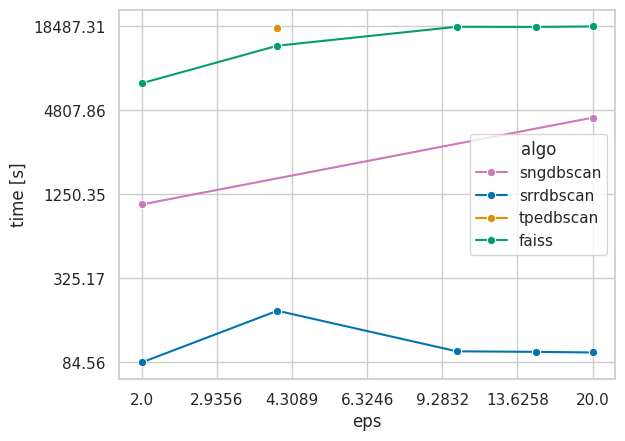

In [43]:
custom_palette = {"srrdbscan": palette[0], 
                  "tpedbscan": palette[1], 
                  "faiss": palette[2], 
                  "sklearn": palette[3], 
                  "sngdbscan": palette[4],
                  "IP.LSH.DBSCAN": palette[4]}

ax = sns.lineplot(data=times, x='eps', y='time', hue="algo", marker='o', palette=custom_palette)
ax.set_ylabel('time [s]')
ax.set_xscale("log")
ax.set_yscale("log")

# Set gridlines and ticks
x_log_min = np.log10(min(times['eps']))
x_log_max = np.log10(max(times['eps']))
xticks = np.logspace(x_log_min, x_log_max, num = 7)
xticks = [round(x, 4) for x in xticks]
y_log_min = np.log10(min(times['time']))
y_log_max = np.log10(max(times['time']))
yticks = np.logspace(y_log_min, y_log_max, num = 5)
yticks = [round(x, 2) for x in yticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

In [44]:
Algo = ['srrdbscan', 'sngdbscan', 'tpedbscan', 'faiss', 'sklearn', 'IP.LSH.DBSCAN']
eps = [1.0, 2.0, 4.0, 5.0, 10.0, 20.0] # glove

M = [[0 for _ in range(len(eps))] for _ in range(len(Algo))]
x=0
y=0

for i in range(len(times)):
    if times["eps"][i] in eps:
        x = Algo.index(times["algo"][i])
        y = eps.index(times["eps"][i])
        M[x][y] = str(round(times["time"][i], 2))

for i in range(len(Algo)):
    for j in range(len(eps)):
        if M[i][j] == 0.0:
            M[i][j] = 'Missing'

for j in range(len(eps)):
    print(str("&"), eps[j], str("&"), 
          M[0][j], str("&"), 
          M[1][j], str("&"), 
          M[2][j], str("&"), 
          M[3][j], str("&"), 
          M[4][j], str(r"\\"))

& 1.0 & Missing & Missing & Missing & Missing & Missing \\
& 2.0 & 84.56 & 1064.84 & Missing & 7433.47 & Missing \\
& 4.0 & 193.69 & Missing & 18017.62 & 13576.07 & Missing \\
& 5.0 & Missing & Missing & Missing & Missing & Missing \\
& 10.0 & 101.1 & Missing & Missing & 18396.08 & Missing \\
& 20.0 & 99.22 & 4282.37 & Missing & 18487.31 & Missing \\


In [45]:
for i in range(len(eps)): 
    print(eps[i])

1.0
2.0
4.0
5.0
10.0
20.0


## Collective running time plot

In [46]:
sets = {"aloi": [27, 0.0005, 0.2], 
    "celeba": [39, 0.4, 8.0], 
    "census": [500, 0.01, 10.0], 
    "gist": [960, 0.2, 10.0], 
    "glove": [100, 1, 20.0], 
    "household": [7, 0.01, 1000.0], 
    "mnist": [784, 500.0, 10000], 
    "pamap2": [4, 0.1, 500.0]}


data = []

for dataset in sets:
    for f in load_all_results(dataset, ".."):
        if dataset == "aloi" or dataset == "mnist" or dataset == "pamap2":
            if f.attrs['algo'] == 'srrdbscan' and f.attrs['params'][16:35].split(",")[0] == '0.1' and "1.0" in f.attrs['params'] :
                data.append({
                    "data": dataset,
                    "eps": (f.attrs['eps'] - sets[dataset][1])/(sets[dataset][2] - sets[dataset][1]),
                    #"eps": f.attrs['eps']/sets[dataset][1],
                    "time": f.attrs['time']/(len(f['labels'])*sets[dataset][0])
                    })
        else:
            if f.attrs['algo'] == 'srrdbscan' and f.attrs['params'][16:35].split(",")[0] == '0.1':
                data.append({
                    "data": dataset,
                    "eps": (f.attrs['eps'] - sets[dataset][1])/(sets[dataset][2] - sets[dataset][1]),
                    #"eps": f.attrs['eps']/sets[dataset][1],
                    "time": f.attrs['time']/(len(f['labels'])*sets[dataset][0])
                    })


df = pd.DataFrame(data=data)
df

,data,eps,time
0,aloi,0.248120,1.840308e-06
1,aloi,0.001504,4.312027e-07
2,aloi,0.007519,3.742121e-07
3,aloi,0.147870,2.600471e-06
4,aloi,0.097744,1.899839e-06
...,...,...,...
107,pamap2,0.019804,4.422527e-06
108,pamap2,1.000000,2.720755e-06
109,pamap2,1.000000,2.529102e-06
110,pamap2,0.002801,3.826029e-06


In [47]:
x_log_min = np.log10(min(df['eps']))
x_log_max = np.log10(max(df['eps']))

df['eps']

/tmp/ipykernel_284953/665235534.py:1: RuntimeWarning: divide by zero encountered in log10
  x_log_min = np.log10(min(df['eps']))


0      0.248120
1      0.001504
2      0.007519
3      0.147870
4      0.097744
         ...   
107    0.019804
108    1.000000
109    1.000000
110    0.002801
111    0.002801
Name: eps, Length: 112, dtype: float64

/tmp/ipykernel_284953/558139977.py:4: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  ax = sns.lineplot(data=df, x='eps', y='time', hue="data", marker='o', markersize = 7, linewidth = 2.5, palette=palette)
/tmp/ipykernel_284953/558139977.py:13: RuntimeWarning: divide by zero encountered in log10
  x_log_min = np.log10(min(df['eps']))
/home/cabi/.local/lib/python3.8/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/cabi/.local/lib/python3.8/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start


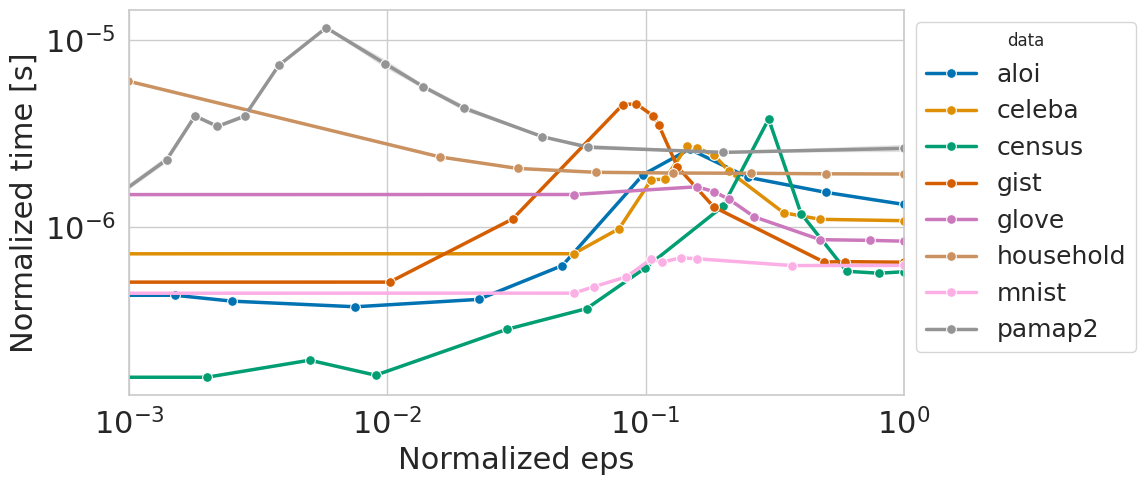

In [48]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax = sns.lineplot(data=df, x='eps', y='time', hue="data", marker='o', markersize = 7, linewidth = 2.5, palette=palette)
ax.set_xlim(0.001, 1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Normalized eps", fontsize = 22)
ax.set_ylabel("Normalized time [s]", fontsize = 22)

x_log_min = np.log10(min(df['eps']))
x_log_max = np.log10(max(df['eps']))
xticks = np.logspace(x_log_min, x_log_max, num = 7)
xticks = [round(x, 4) for x in xticks]
y_log_min = np.log10(min(df['time']))
y_log_max = np.log10(max(df['time']))

ax.xaxis.set_tick_params(labelsize = 22)
ax.yaxis.set_tick_params(labelsize = 22)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize = 18)